In [1]:
%matplotlib inline
import sys
import numpy as np
import sklearn as skl
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('./fashion-mnist/utils')
import mnist_reader
sns.set_style('darkgrid')

In [2]:
dataset_path = './fashion-mnist/data/fashion'
training_img, training_label = mnist_reader.load_mnist(dataset_path, kind='train')
testing_img, testing_label = mnist_reader.load_mnist(dataset_path, kind='t10k')

training_img = training_img.astype(np.float32) / 255.
testing_img = testing_img.astype(np.float32) / 255.

print training_img.shape


(60000, 784)


In [3]:
print len(training_img)
print len(testing_img)

60000
10000


In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
reduced_train_img = pca.fit_transform(training_img)
print 'Information left: ', np.sum(pca.explained_variance_ratio_)

Information left:  0.765204


Search meta-parameters
Reference: https://github.com/thuijskens/bayesian-optimization/blob/master/ipython-notebooks/svm-optimization.ipynb

In [5]:
def sample_loss(params): ## log scale
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1]),
                           reduced_train_img, training_label, cv=3, n_jobs=3).mean()


In [6]:
lambdas = np.linspace(1, -4, 5) ## from 0.0001 ~ 10 in 5 steps (log scale)
gammas = np.linspace(1, -4, 4)
# sample_loss([0,0])
# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

real_loss = [sample_loss(params) for params in param_grid]

/Users/kuang-yujeng/Library/Python/2.7/lib/python/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/kuang-yujeng/Library/Python/2.7/lib/python/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


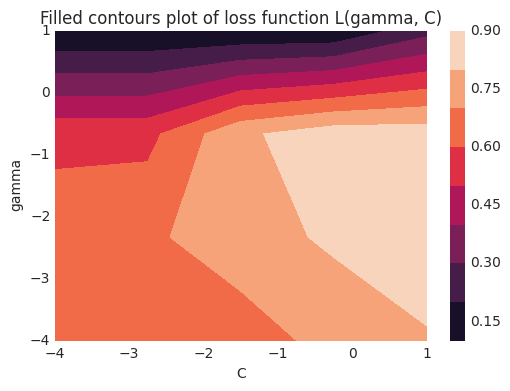

-0.25 -0.666666666667


In [7]:
C, G = np.meshgrid(lambdas, gammas)
ax = plt.subplot()
cp = ax.contourf(C, G, np.array(real_loss).reshape(C.shape))
cbar = plt.colorbar(cp, ticks=np.arange(0., 1.0, 0.15))
ax.set_title('Filled contours plot of loss function L(gamma, C)')
ax.set_xlabel('C')
ax.set_ylabel('gamma')
plt.show()

# The maximum is at:
C, gamma = param_grid[np.array(real_loss).argmax(), :]
print C, gamma

In [8]:
clf = SVC(C=10**C, gamma=10**gamma, verbose=False)
# clf = SVC(verbose=True)

10-fold Cross-validation

In [9]:
scores = cross_val_score(clf, reduced_train_img, training_label, cv=10, n_jobs=3)
print ''
print '-'*8+' 10-fold cross-validation '+'-'*8
for s in scores:
    print s
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


-------- 10-fold cross-validation --------
0.863333333333
0.863333333333
0.8595
0.855666666667
0.867
0.864666666667
0.865666666667
0.862333333333
0.861166666667
0.8555
Accuracy: 0.86 (+/- 0.01)


Okay. Now testing on testing set.

In [10]:
reduced_testing_img = pca.transform(testing_img)
%time clf.fit(reduced_train_img, training_label)
predicted = clf.predict(reduced_testing_img)
confusion_metrix = skl.metrics.confusion_matrix(testing_label, predicted)
print confusion_metrix
inclass_precision = skl.metrics.classification_report(testing_label, predicted)
print inclass_precision

CPU times: user 2min 3s, sys: 2.49 s, total: 2min 5s
Wall time: 2min 9s
[[834   0  19  32   3   2  96   0  14   0]
 [ 10 945   5  29   5   0   5   0   1   0]
 [ 11   0 795  15  90   0  82   0   7   0]
 [ 34  11  13 875  31   0  33   0   3   0]
 [  0   0 125  37 756   0  77   0   5   0]
 [  1   0   0   0   0 918   0  50   5  26]
 [147   0 120  27  94   0 591   0  21   0]
 [  0   0   0   0   0  29   0 921   2  48]
 [  3   0   4   4   2   4   7   3 972   1]
 [  0   0   0   0   0  16   0  39   5 940]]
             precision    recall  f1-score   support

          0       0.80      0.83      0.82      1000
          1       0.99      0.94      0.97      1000
          2       0.74      0.80      0.76      1000
          3       0.86      0.88      0.87      1000
          4       0.77      0.76      0.76      1000
          5       0.95      0.92      0.93      1000
          6       0.66      0.59      0.63      1000
          7       0.91      0.92      0.92      1000
          8       0

In [11]:
mean_score_on_testing_set = clf.score(reduced_testing_img, testing_label)
print 'score on testing set:', mean_score_on_testing_set

score on testing set: 0.8547


In [12]:
def plot_embedding(x_emb,y,n,title=''):
    cmap = plt.cm.gist_ncar_r
    ax = plt.subplot()
    for l in xrange(n):
        points = x_emb[y==l,:]
        ax.scatter(points[:,0], points[:,1], label=l, c=cmap(float(l)/float(n)))
    ax.legend(loc='lower right', frameon=True, prop={'size': 10})
    ax.set_title(title)
    plt.show()

In [13]:
from sklearn.manifold import TSNE as tSNE

tsne = tSNE(n_components=2)
# tsne = PCA(n_components=2)
emb_testing_img = tsne.fit_transform(testing_img)

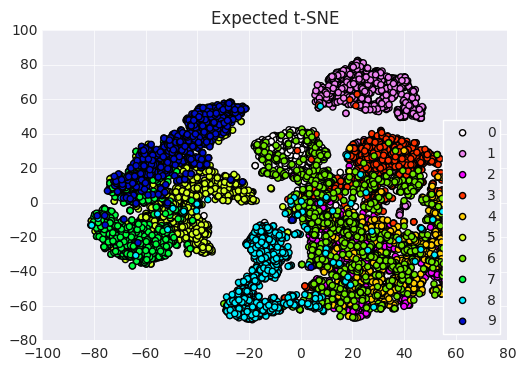

In [14]:
plot_embedding(emb_testing_img, testing_label, 10, 'Expected t-SNE')

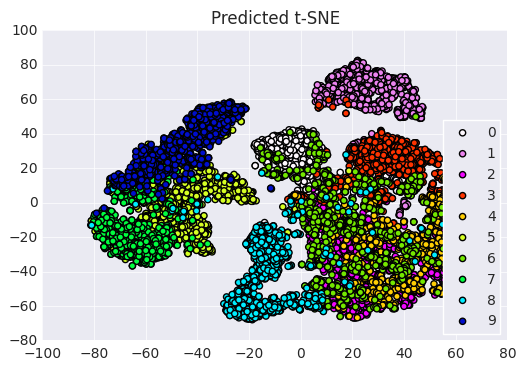

In [15]:
plot_embedding(emb_testing_img, predicted, 10, 'Predicted t-SNE')